In [99]:
import lightkurve as lk
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from lightkurve.periodogram import BoxLeastSquaresPeriodogram
from lightkurve import LightCurveCollection
import matplotlib.pyplot as plt
from astropy import units as u
from lightkurve import search_lightcurve
import numpy as np
from pathlib import Path
import shutil
import glob
import pandas as pd
import os

In [4]:
planet = input("Gezegen adı gir (örn: Kepler-10 b): ")

def sanitize_name(name: str) -> str:
    import re
    s = re.sub(r"[^\w\-_\. ]", "_", name).strip()
    return s.replace(" ", "_")

planet_sanitized = sanitize_name(planet)
outdir = Path(f"./{planet_sanitized}")
outdir.mkdir(parents=True, exist_ok=True)
print(f"Çıktılar {outdir} içine kaydedilecek.")

# NASA Exoplanet Archive'den gezegen bilgisi çekme
tbl = NasaExoplanetArchive.query_criteria(
    table="pscomppars",
    select="pl_name,hostname,pl_orbper",
    where=f"pl_name='{planet}'"
)
if len(tbl) == 0:
    raise RuntimeError(f"{planet} bulunamadı. İsim formatını kontrol et!")

P_catalog = tbl["pl_orbper"][0].to_value("d")  # birimi 'd' (gün) olarak çıkar
host = str(tbl["hostname"][0])
print(f"{planet} için katalog periyodu: {P_catalog} gün, host: {host}")

Gezegen adı gir (örn: Kepler-10 b):  Kepler-10 b


Çıktılar Kepler-10_b içine kaydedilecek.
Kepler-10 b için katalog periyodu: 0.8374907 gün, host: Kepler-10


In [5]:
#MAST arşivinden verilen host için ışık eğrisi verilerini arama
search_result = lk.search_lightcurve(host, author="Kepler", cadence="long")
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 00,2009,Kepler,1800,kplr011904151,0.0
1,Kepler Quarter 01,2009,Kepler,1800,kplr011904151,0.0
2,Kepler Quarter 02,2009,Kepler,1800,kplr011904151,0.0
3,Kepler Quarter 03,2009,Kepler,1800,kplr011904151,0.0
4,Kepler Quarter 04,2010,Kepler,1800,kplr011904151,0.0
5,Kepler Quarter 05,2010,Kepler,1800,kplr011904151,0.0
6,Kepler Quarter 06,2010,Kepler,1800,kplr011904151,0.0
7,Kepler Quarter 07,2010,Kepler,1800,kplr011904151,0.0
8,Kepler Quarter 09,2011,Kepler,1800,kplr011904151,0.0


In [6]:
print("İndiriliyor: tüm lightcurve dosyaları ->", outdir)

lc_collection = search_result.download_all(download_dir=str(outdir))
lc_collection
#Tüm ışık eğrisi dosyalarını indirir ve lc_Collection nesnesi olarak saklar

İndiriliyor: tüm lightcurve dosyaları -> Kepler-10_b


LightCurveCollection of 15 objects:
    0: <KeplerLightCurve LABEL="KIC 11904151" QUARTER=0 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    1: <KeplerLightCurve LABEL="KIC 11904151" QUARTER=1 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    2: <KeplerLightCurve LABEL="KIC 11904151" QUARTER=2 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    3: <KeplerLightCurve LABEL="KIC 11904151" QUARTER=3 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    4: <KeplerLightCurve LABEL="KIC 11904151" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    5: <KeplerLightCurve LABEL="KIC 11904151" QUARTER=5 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    6: <KeplerLightCurve LABEL="KIC 11904151" QUARTER=6 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    7: <KeplerLightCurve LABEL="KIC 11904151" QUARTER=7 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    8: <KeplerLightCurve LABEL="KIC 11904151" QUARTER=9 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    9: <KeplerLightCurve LABEL="KIC 11904151" QUARTER=10 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    10: <Kepl

In [65]:
tpf = lk.search_targetpixelfile(planet, author="Kepler", cadence="long").download_all(download_dir=str(outdir))
print("TPF kaydedildi:")
print("İndirilen TPF sayısı:", len(tpf))

TPF kaydedildi:
İndirilen TPF sayısı: 15


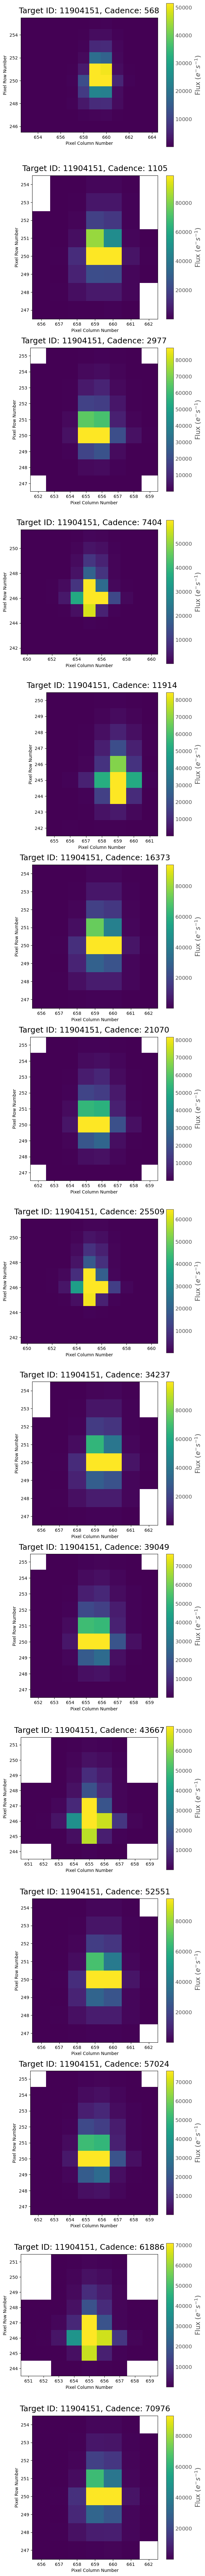

In [8]:
tpf
tpf.plot();

In [46]:
lc_collection = []

for i, t in enumerate(tpf):
    lc = t.to_lightcurve(aperture_mask=t.pipeline_mask).flatten(window_length=101).remove_nans().remove_outliers()
    globals()[f"lc_{i}"] = lc
    lc_collection.append(lc)
    print(f"lc_{i} oluşturuldu ve lc_collection'a eklendi.")


lc_0 oluşturuldu ve lc_collection'a eklendi.
lc_1 oluşturuldu ve lc_collection'a eklendi.
lc_2 oluşturuldu ve lc_collection'a eklendi.
lc_3 oluşturuldu ve lc_collection'a eklendi.
lc_4 oluşturuldu ve lc_collection'a eklendi.
lc_5 oluşturuldu ve lc_collection'a eklendi.
lc_6 oluşturuldu ve lc_collection'a eklendi.
lc_7 oluşturuldu ve lc_collection'a eklendi.
lc_8 oluşturuldu ve lc_collection'a eklendi.
lc_9 oluşturuldu ve lc_collection'a eklendi.
lc_10 oluşturuldu ve lc_collection'a eklendi.
lc_11 oluşturuldu ve lc_collection'a eklendi.
lc_12 oluşturuldu ve lc_collection'a eklendi.
lc_13 oluşturuldu ve lc_collection'a eklendi.
lc_14 oluşturuldu ve lc_collection'a eklendi.


In [47]:
lc_collection

[<KeplerLightCurve length=472 LABEL="KIC 11904151" QUARTER=0 CAMPAIGN=None>
        time               flux               flux_err           centroid_col      centroid_row    cadenceno quality
                                                                     pix               pix                          
        Time             float64              float64              float64           float64         int32    int32 
 ------------------ ------------------ ---------------------- ----------------- ------------------ --------- -------
  120.5391465105713 1.0000764994059563  3.755292496032327e-05  659.357989684006 250.30442570279038       568       0
 120.55958073025249 1.0001079431238293  3.755332604351815e-05 659.3582852060331 250.30472373806552       569       0
 120.58001484981651 1.0000976173849054  3.755361612248091e-05 659.3582977496102 250.30433534695487       570       0
 120.60044916937477 0.9999398108794475 3.7550681765488504e-05 659.3587442581675 250.30420265342784       

In [48]:
lc_collection = LightCurveCollection(lc_collection)
lc_stitched = lc_collection.stitch()
lc_stitched

time,flux,flux_err,centroid_col,centroid_row,cadenceno,quality
,,,pix,pix,,
Time,float64,float64,float64,float64,int32,int32
120.5391465105713,1.0000742113287913,3.7552839042905814e-05,659.357989684006,250.30442570279038,568,0
120.55958073025249,1.000105654974724,3.755324012518306e-05,659.3582852060331,250.30472373806552,569,0
120.58001484981651,1.0000953292594246,3.755353020348215e-05,659.3582977496102,250.30433534695487,570,0
120.60044916937477,0.9999375231150124,3.755059585320326e-05,659.3587442581675,250.30420265342784,571,0
120.62088338893955,1.0001198490725351,3.755360521484007e-05,659.3589580343972,250.30414353808996,572,0
120.64131750838715,1.0000022878008399,3.75514800996508e-05,659.3589930999345,250.3035492197216,573,0
120.66175172782823,0.999834865167472,3.754898787737611e-05,659.3592364409575,250.30377748636084,574,0
120.68218604727736,0.9998349836569702,3.754905570930622e-05,659.359124887123,250.3036923202359,575,0


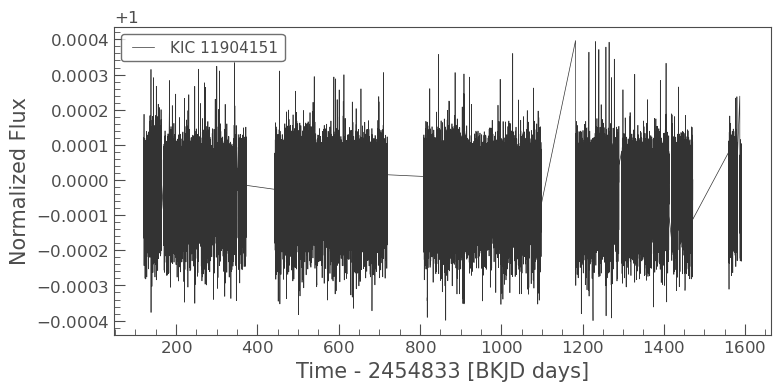

In [91]:
lc_stitched.plot();
plt.savefig("stitched_lightcurve.png", dpi=300)
plt.show()

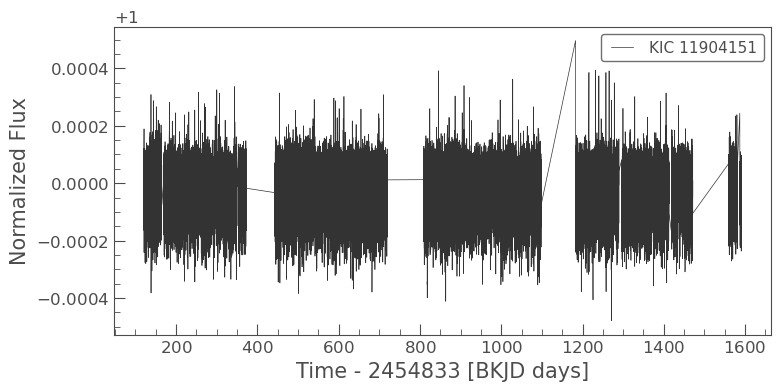

In [50]:
flat_lc = lc_stitched.flatten(window_length=401)
flat_lc.plot();
plt.show()

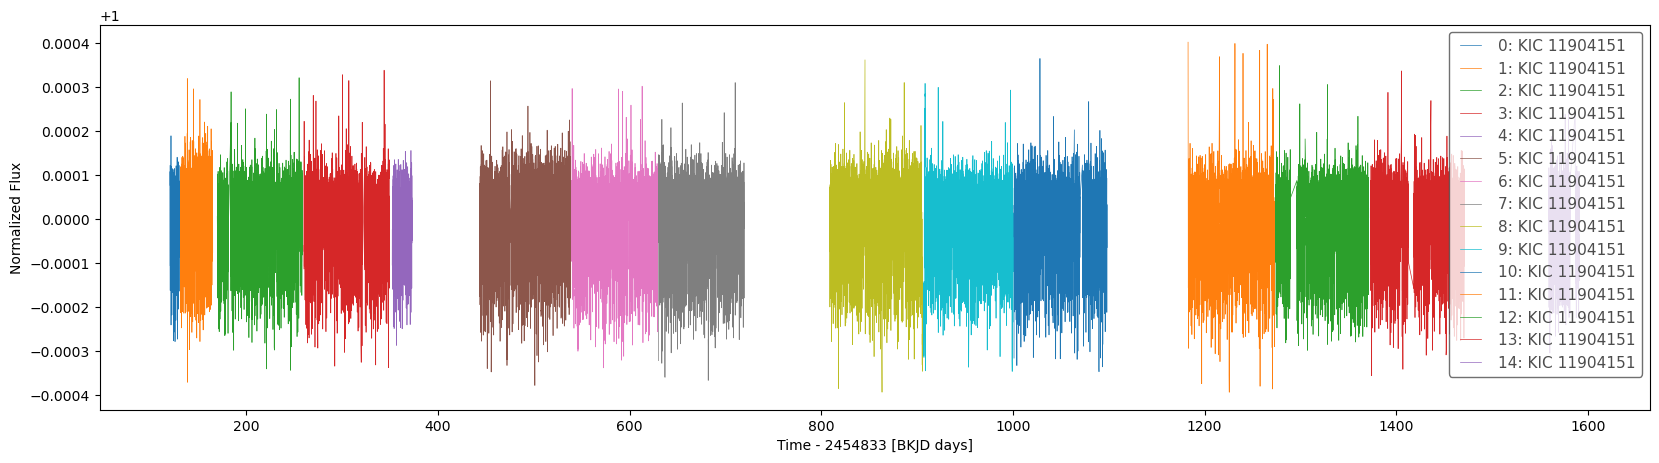

In [51]:
fig, ax = plt.subplots(figsize=(20,5))
lc_collection.plot(ax=ax);

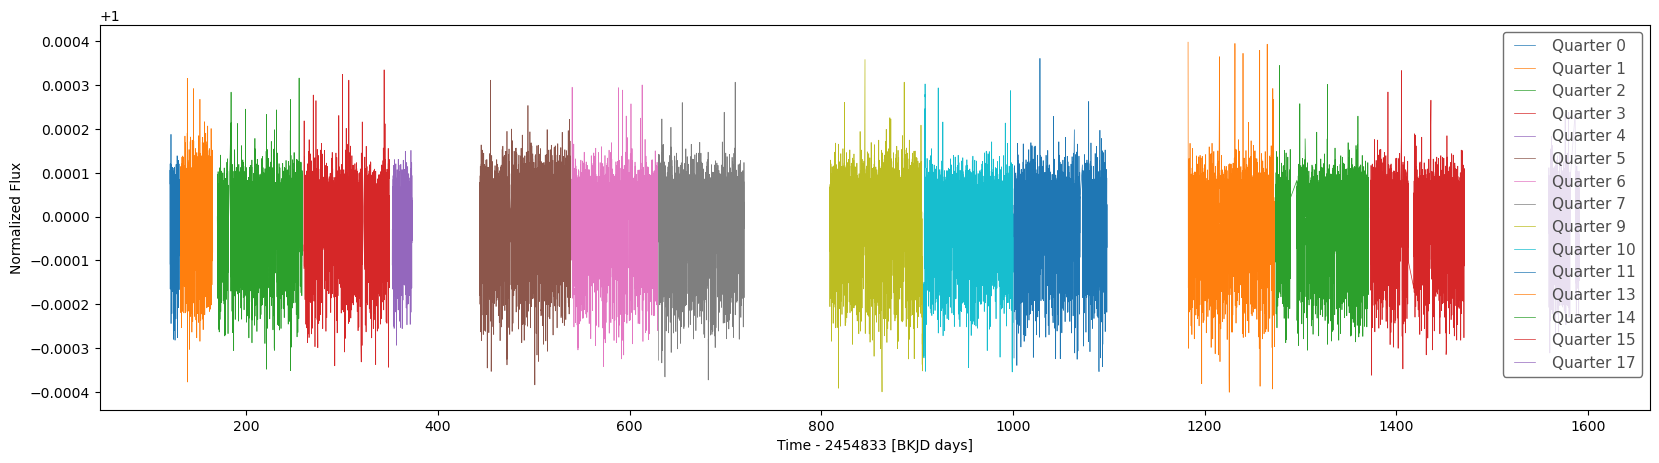

In [52]:
fig, ax = plt.subplots(figsize=(20,5))
for lc in lc_collection:
  lc.normalize().plot(ax=ax, label=f'Quarter {lc.quarter}');

In [66]:
min_period, max_period = 0.5, ((lc_stitched.time[-1].value - lc_stitched.time[0].value) / 3) / len(tpf)
print(min_period, max_period)

0.5 32.67694516363198


In [54]:
from lightkurve.periodogram import BoxLeastSquaresPeriodogram

periods = [] 
for i, lc in enumerate(lc_collection):
    try:
        lc_clean = lc.remove_nans().remove_outliers()
        bls = lc_clean.to_periodogram(method="bls",minimum_period=min_period, maximum_period=max_period)
        bls_period = bls.period_at_max_power.value
        periods.append(bls_period)
        print(f"lc_{i} için bulunan periyot: {bls_period:.5f} d")

    except Exception as e:
        print(f"lc_{i} için hata oluştu: {e}")

# ortalama periyot
if periods:
    expected = P_catalog   
    tol = 0.1      

    # filtreleme
    filtered_periods = [p for p in periods if abs(p - expected) < tol]

    if filtered_periods:
        avg_period = np.mean(filtered_periods)
        print("\nBulunan periyotlar:", [f"{p:.5f}" for p in periods])
        print("Filtrelenmiş periyotlar:", [f"{p:.5f}" for p in filtered_periods])
        print(f"Ortalama periyot (filtreli): {avg_period:.5f} d")
    else:
        print("Filtreye uyan periyot bulunamadı.")
else:
    print("Hiç periyot bulunamadı.")

lc_0 için bulunan periyot: 0.83801 d
lc_1 için bulunan periyot: 0.83785 d
lc_2 için bulunan periyot: 0.83773 d
lc_3 için bulunan periyot: 0.83780 d
lc_4 için bulunan periyot: 0.83733 d
lc_5 için bulunan periyot: 0.83776 d
lc_6 için bulunan periyot: 0.83779 d
lc_7 için bulunan periyot: 0.83777 d
lc_8 için bulunan periyot: 0.83775 d
lc_9 için bulunan periyot: 0.83773 d
lc_10 için bulunan periyot: 0.83770 d
lc_11 için bulunan periyot: 0.83777 d
lc_12 için bulunan periyot: 0.83773 d
lc_13 için bulunan periyot: 0.83770 d
lc_14 için bulunan periyot: 0.83767 d

Bulunan periyotlar: ['0.83801', '0.83785', '0.83773', '0.83780', '0.83733', '0.83776', '0.83779', '0.83777', '0.83775', '0.83773', '0.83770', '0.83777', '0.83773', '0.83770', '0.83767']
Filtrelenmiş periyotlar: ['0.83801', '0.83785', '0.83773', '0.83780', '0.83733', '0.83776', '0.83779', '0.83777', '0.83775', '0.83773', '0.83770', '0.83777', '0.83773', '0.83770', '0.83767']
Ortalama periyot (filtreli): 0.83774 d


BLS ile bulunan periyot: 0.83743 d


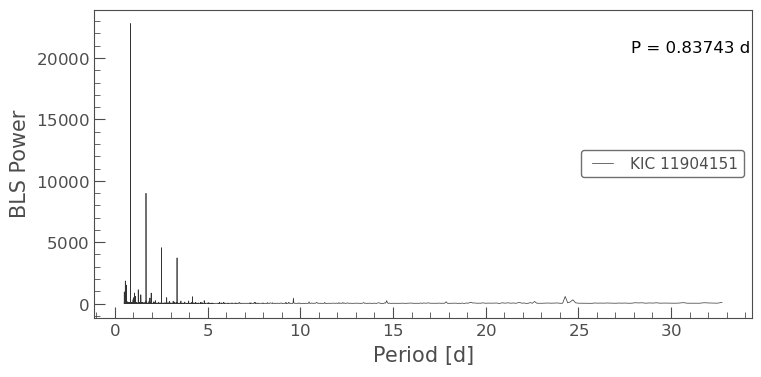

In [76]:
bls = lc_stitched.to_periodogram(method="bls", minimum_period=min_period, maximum_period=max_period, frequency_factor=10000)
bls.plot()
bls_period = bls.period_at_max_power.value
print(f"BLS ile bulunan periyot: {bls_period:.5f} d")

plt.text(0.98, 0.95,f"P = {bls_period:.5f} d",transform=ax.transAxes,fontsize=12,color='black',ha='right', va='top')
plt.savefig("bls_periodogram.png", dpi=300)
plt.show()

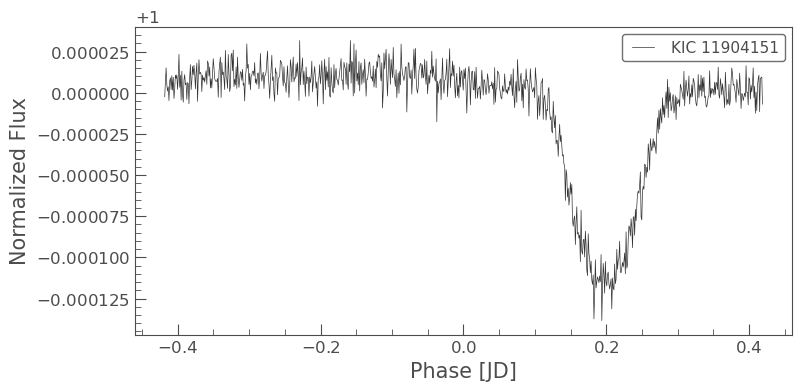

In [97]:
folded_lc = lc_stitched.fold(period=bls_period).bin(time_bin_size=0.001)
folded_lc.plot();
folded_lc.to_table().write("binned_lightcurve.csv", format='csv', overwrite=True)
plt.show()

In [88]:
#Kaydetme İşlemleri

ax = lc_stitched.plot()
plot_path = os.path.join(outdir, "stitched_lightcurve.png")
plt.savefig(plot_path, dpi=300)
plt.close()
ax = folded_lc.plot()
plot_path = os.path.join(outdir, "folded_lightcurve.png")
plt.savefig(plot_path, dpi=300)
plt.close()
ax = bls.plot()
plot_path = os.path.join(outdir, "bls_period.png")
plt.savefig(plot_path, dpi=300)
plt.close()
ax = lc_collection.plot()
plot_path = os.path.join(outdir, "collection_plot.png")
plt.savefig(plot_path, dpi=300)
plt.close()

lc_binned = lc_stitched.bin(time_bin_size=10)
csv_path = os.path.join(outdir, "binned_lightcurve.csv")
folded_lc.to_table().write(csv_path, format='csv', overwrite=True)

print(f"Görseller ve CSV '{outdir}' klasörüne kaydedildi.")

Görseller ve CSV 'Kepler-10_b' klasörüne kaydedildi.


In [104]:
#mastdowload silmek için
mast_path = outdir / "mastDownload"

if mast_path.exists():
    try:
        shutil.rmtree(mast_path)
        print(f"{mast_path} klasörü silindi (ham MAST indirmeleri temizlendi).")
    except Exception as e:
        print(f"{mast_path} silinirken hata oluştu: {e}")
else:
    print("mastDownload klasörü bulunamadı.")

Kepler-10_b\mastDownload silinirken hata oluştu: [WinError 32] Dosya başka bir işlem tarafından kullanıldığından bu işlem dosyaya erişemiyor: 'Kepler-10_b\\mastDownload\\Kepler\\kplr011904151_lc_Q111111110111011101\\kplr011904151-2009131105131_lpd-targ.fits.gz'
